# Income Classification

1. [Daten laden und Dataframe erzeugen](#data)
2. [Deskriptive Statistik](#descriptive)
3. [Visualisierung und Daten aufbereiten](#visual)
4. [Kodierung & Skalierung der Daten](#scale)
5. [PCA](#pca)
6. [Clustering](#clustering)
7. [Modelle](#models)
    * [Logit mit original Daten](#logit)
    * [Logit mit PCA](#logit-pca)
    * [Logit mit nicht lineaer transformierten Daten](#logit-transformed)
    * [Random Forest](#random-forest)
    * [Neuronales Netz](#neruonal)
8. [Vergleich der Modelle](#compare)

## Offene Todos
- Vergleich der Modelle
- Neuronales Netz mit PCA Daten
- neuronales Netz speichern und laden
- Random Forest mit PCA Daten
- Sensitivität und  von confusion matrix
- Notebook dokumentieren
- cpaital-gain und capital loss deckeln statt logartihmieren, binär codieren

#### Imports

In [292]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import category_encoders as ce
import tensorflow as tf
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels
from statsmodels.discrete.discrete_model import Logit 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.cluster import KMeans
import keras_tuner
import keras
import matplotlib.ticker as mticker
import math
from sklearn.tree import plot_tree

## Daten laden und Dataframe erzeugen <a class="data" id="data"></a>

In [293]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])
df = pd.concat([train_df, test_df])
df.reset_index(drop=True, inplace=True)
df.index = range(0, len(df))
df_size = df.shape[0]

print(f'Dataset Size: {df_size}')

Dataset Size: 48842


Wir verändern die Zielgröße und verwenden **1** für die Klasse **>50k** und **0** für die Klasse **<=50k**. Es fäält auf, dass **education-num** bereits die Variable **education** als numerische Werte abbildet, alleridngs von 0 bis 16. Das ist unbrauchbar.

In [294]:
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
df = df.drop('education-num', axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   marital-status  48842 non-null  object
 5   occupation      46033 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  47985 non-null  object
 13  income          48842 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


Der Datensatz enthält einige **NaN** Werte. Diese ersetzen wir durch die jeweils am häufigsten vorkommenden Werte der jeweiligen Input-Variable.

In [295]:
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [296]:
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)   

df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)

df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Deskriptive Statistik <a class="descriptive" id="descriptive"></a>

### Numerische Variablen

In [297]:
numeric = [var for var in df.columns if df[var].dtype!=object]
numeric.remove("income")
print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

df.describe().T


There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0
income,48842.0,0.239282,0.426649,0.0,0.0,0.0,0.0,1.0


### Kategoriale Variablen

In [298]:
categorical = [var for var in df.columns if df[var].dtype==object]


print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(df[var].unique())} labels')

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels


## Visualisierung und Daten aufbereiten <a class="visual" id="visual"></a>

Bevor wir die Daten weiter bearbeiten, schauen wir uns zunächst einmal verschiedene Visualisierungen dazu an, um entscheiden zu können, was wir mit den Daten machen:

### Verteilung von **income**

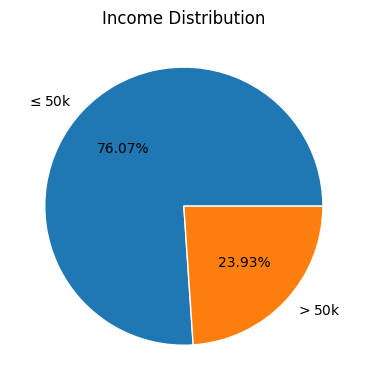

In [299]:
plt.figure(figsize=(4,4))
df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.savefig('figs/income_distribution.png')
plt.show()

### Korrelationsmatrix der numerischen Variablen

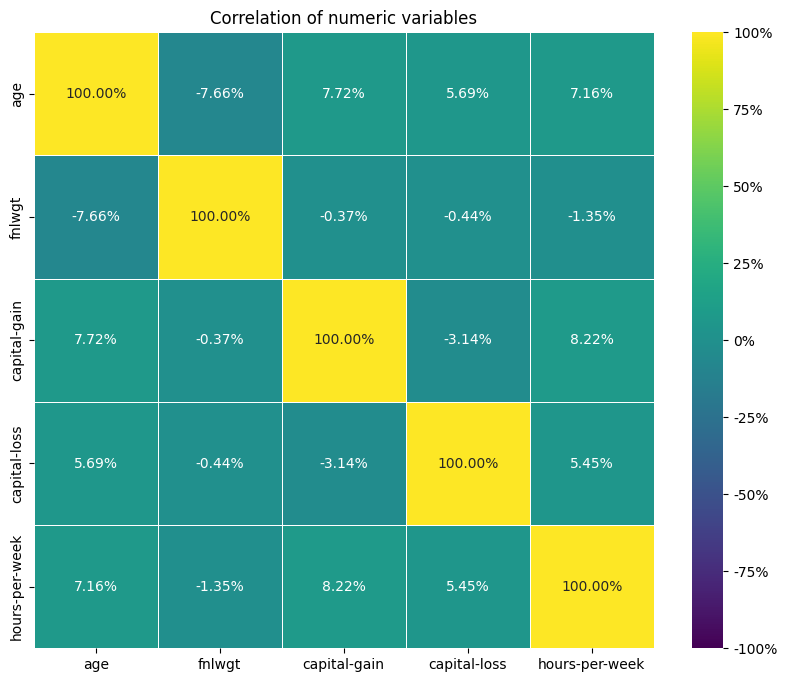

In [300]:
plt.figure(figsize=(10,8), dpi=100)
sns.heatmap(df[numeric].corr(), cmap="viridis", fmt=".2%",linewidth=0.5, annot=True, vmin=-1, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title("Correlation of numeric variables")
plt.savefig('figs/correlation.png')
plt.show()

### Numerische Variablen bezogen auf **income**

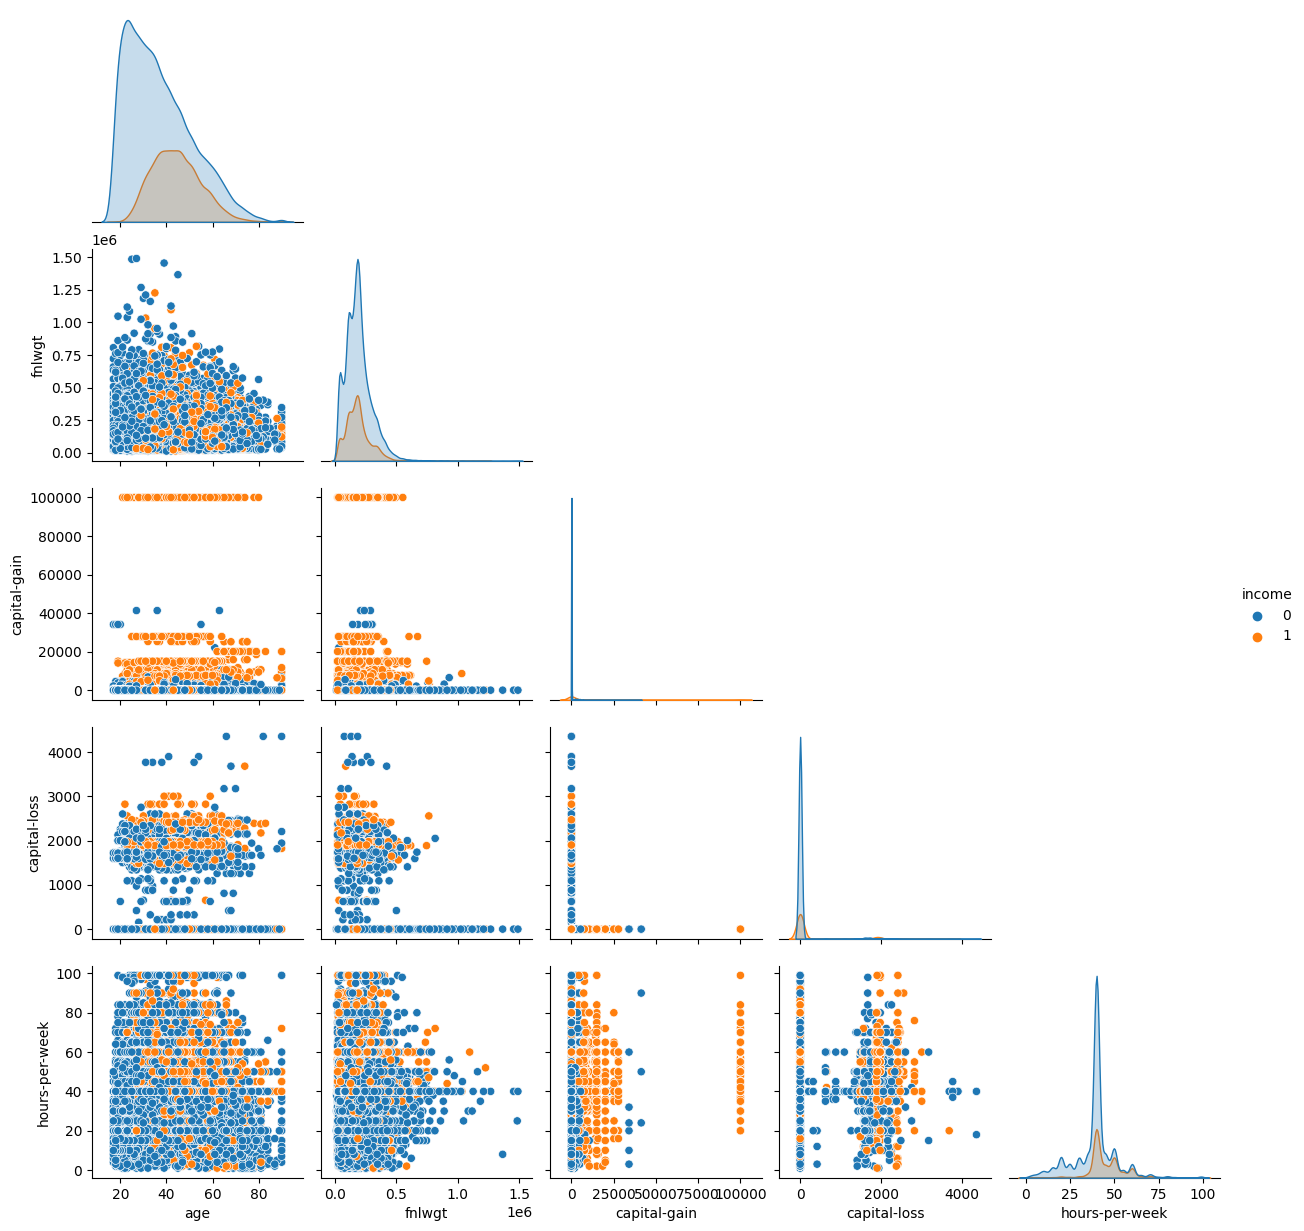

In [301]:
sns.pairplot(df.drop(categorical, axis=1), hue='income', corner=True)
plt.savefig('figs/pair_plot.png')
plt.show()

### Histogramm und Boxplots der numerischen Variablen

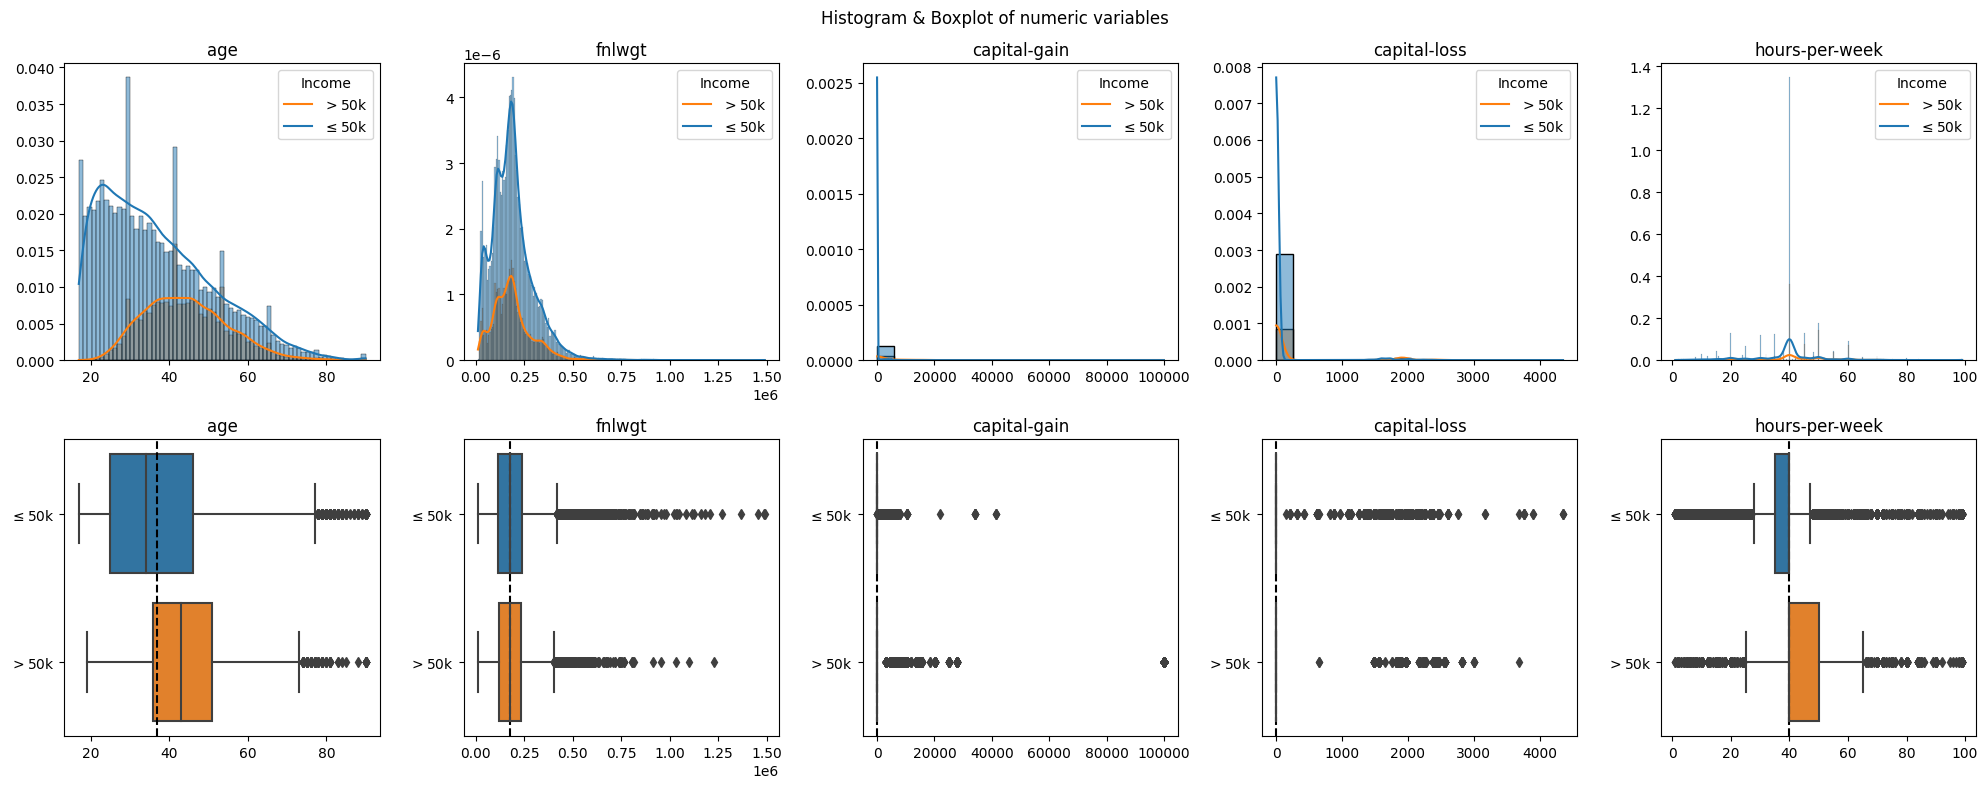

In [302]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$>50$k', '$\leq50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.savefig('figs/histogram_boxplot.png')
plt.show()

### Ausreißer behandeln

Wir transformieren **capital-gain** und **capital-loss** mit dem log(x+1) um Ausreißer zu behandeln. x+1, da die features Werte gleich 0 enthalten und dafür der log nicht definiert ist. 

In [303]:
#df['capital-gain'] = np.log(df['capital-gain'] + 1)
#df['capital-loss'] = np.log(df['capital-loss'] + 1)

df['capital-gain'] = np.where(df['capital-gain'] > 100, 100, df['capital-gain'])
df['capital-loss'] = np.where(df['capital-loss'] > 50, 50, df['capital-loss'])

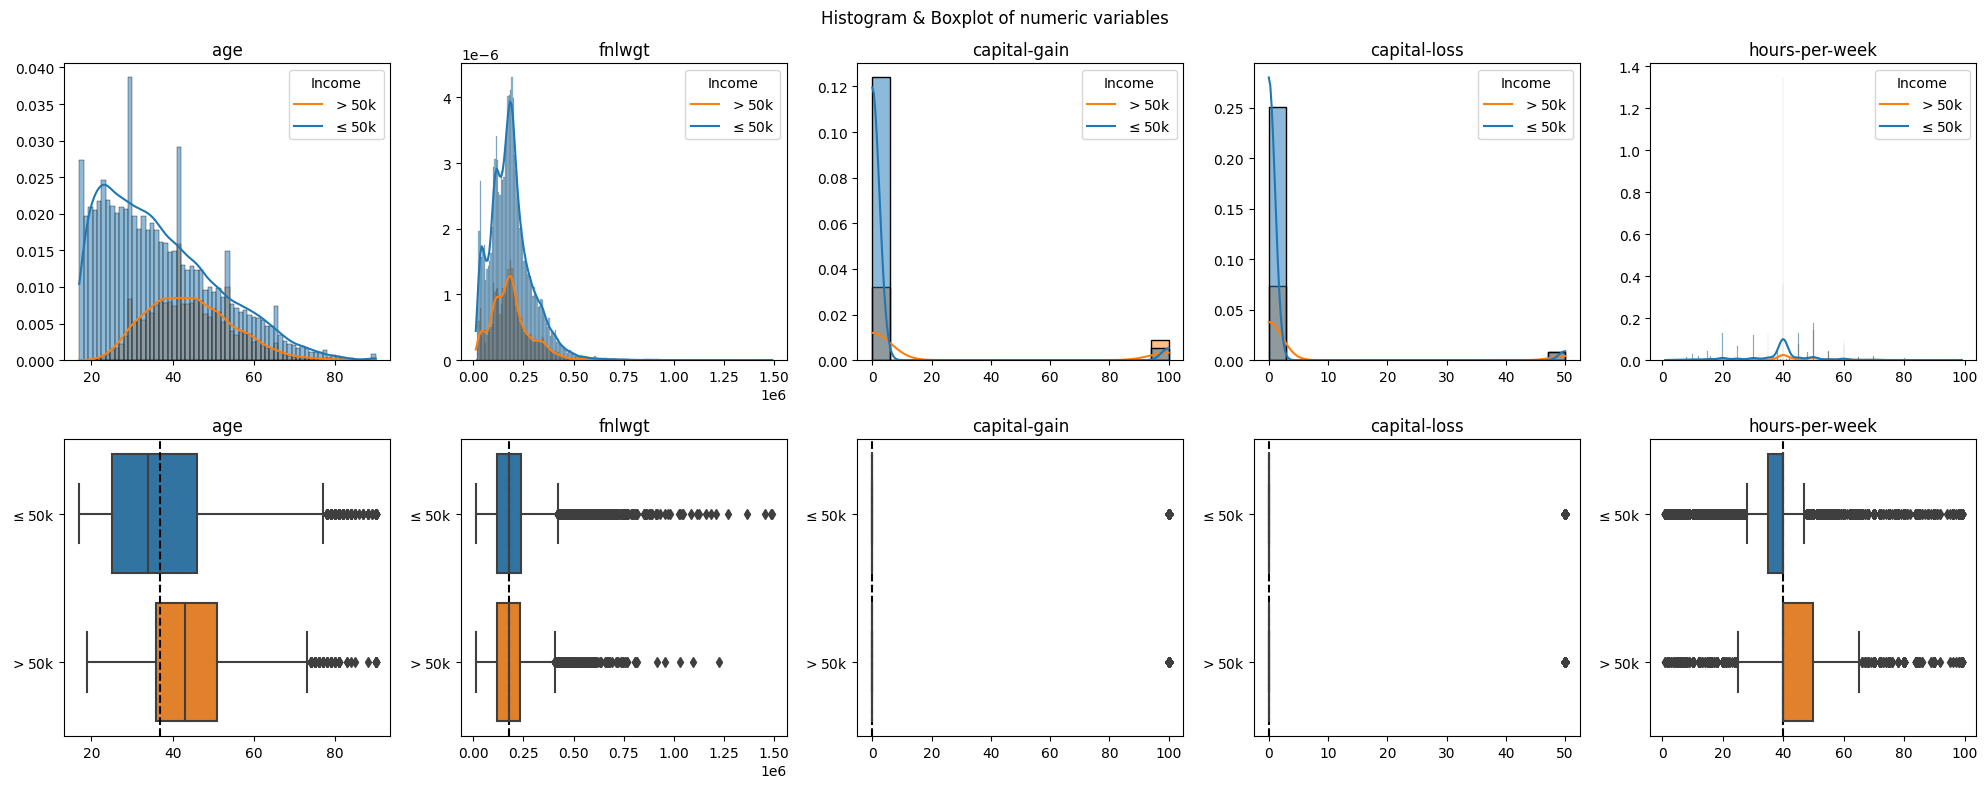

In [304]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")


for i, variable in enumerate(numeric):
    sns.histplot(data=df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$>50$k', '$\leq50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.savefig('figs/histogram_boxplot_modified.png')
plt.show()

### Verteilung der kategorialen Variablen

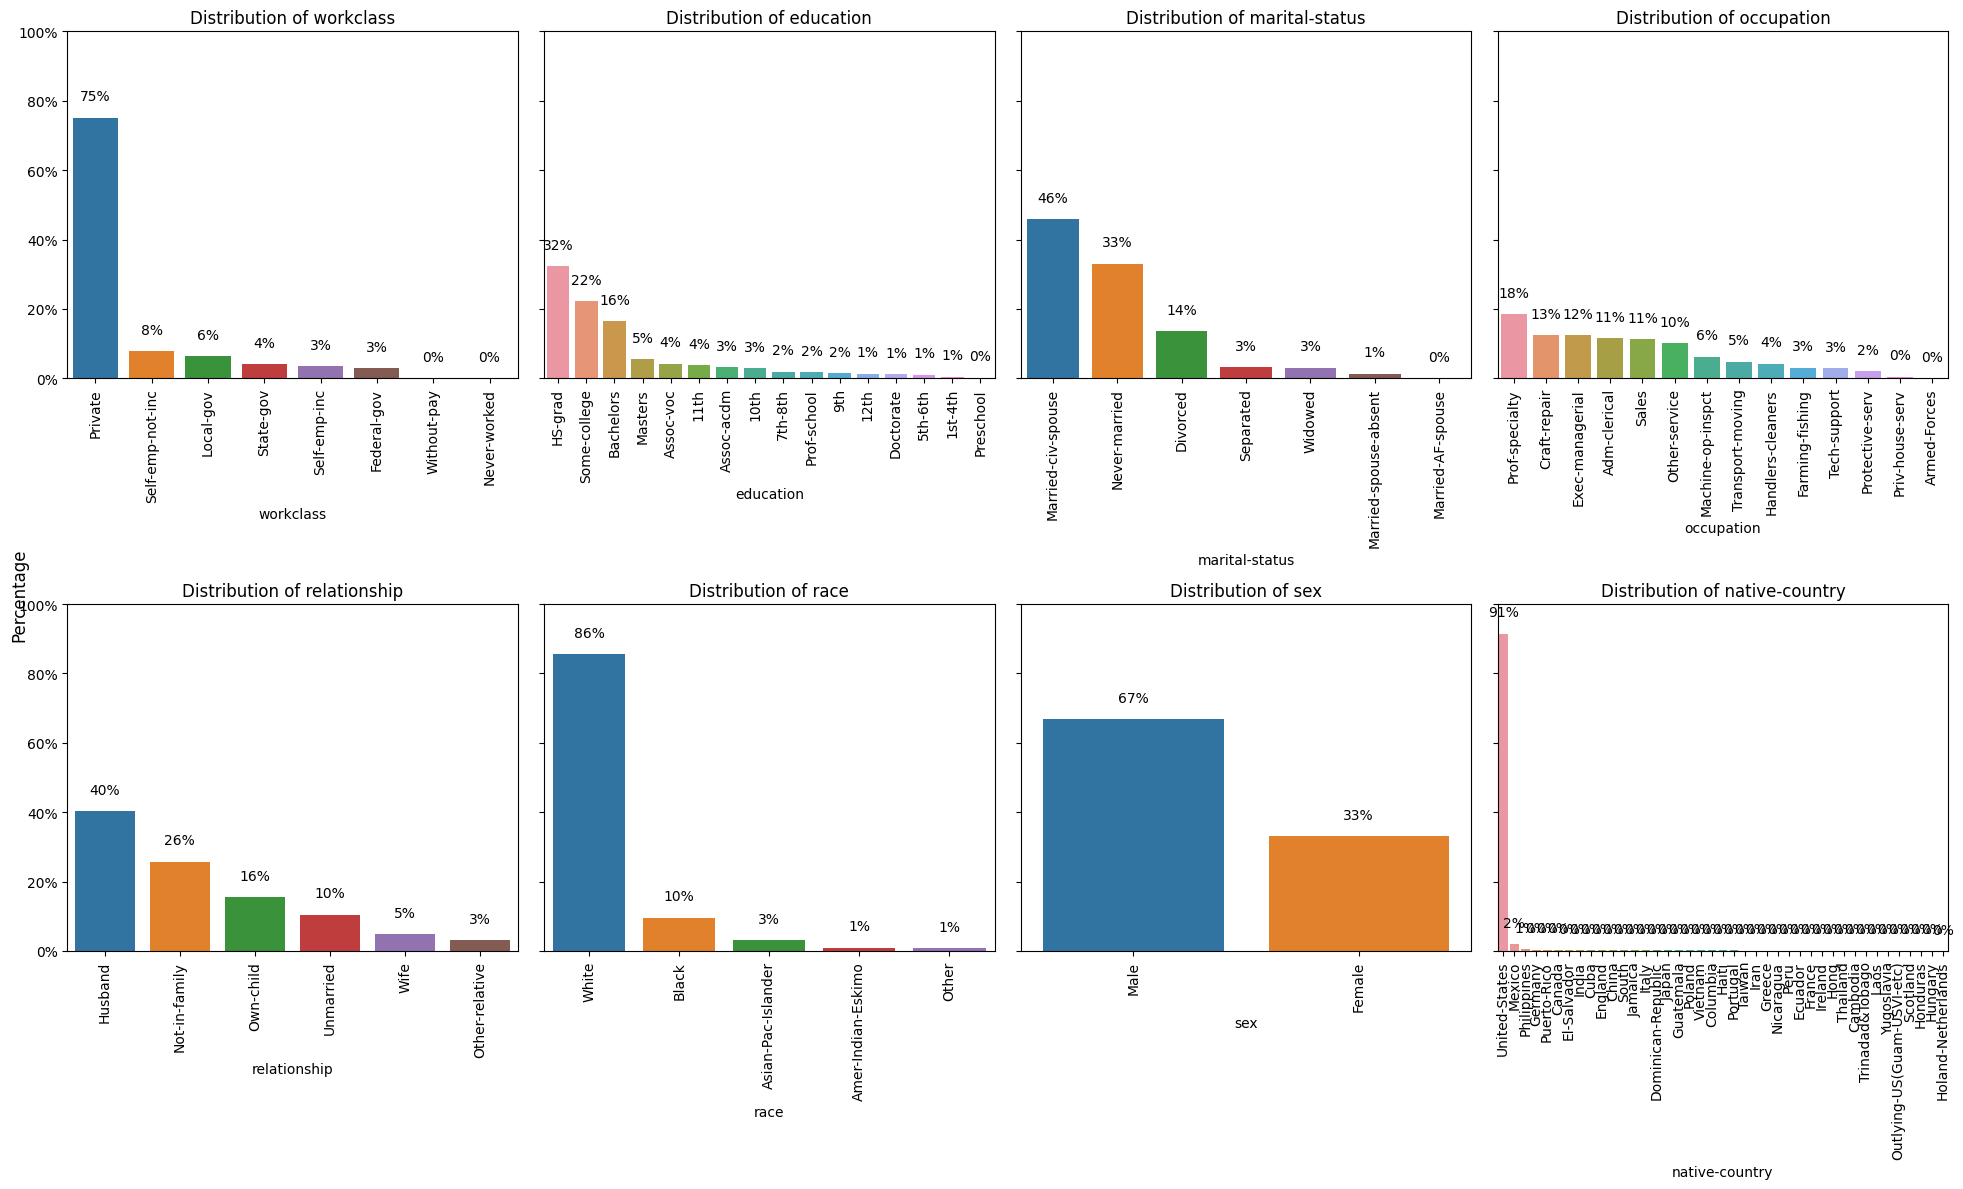

In [305]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.savefig('figs/distribution_categorical.png')
plt.show()

### Verteilung der kategorialen Variablen bezogen auf **income**

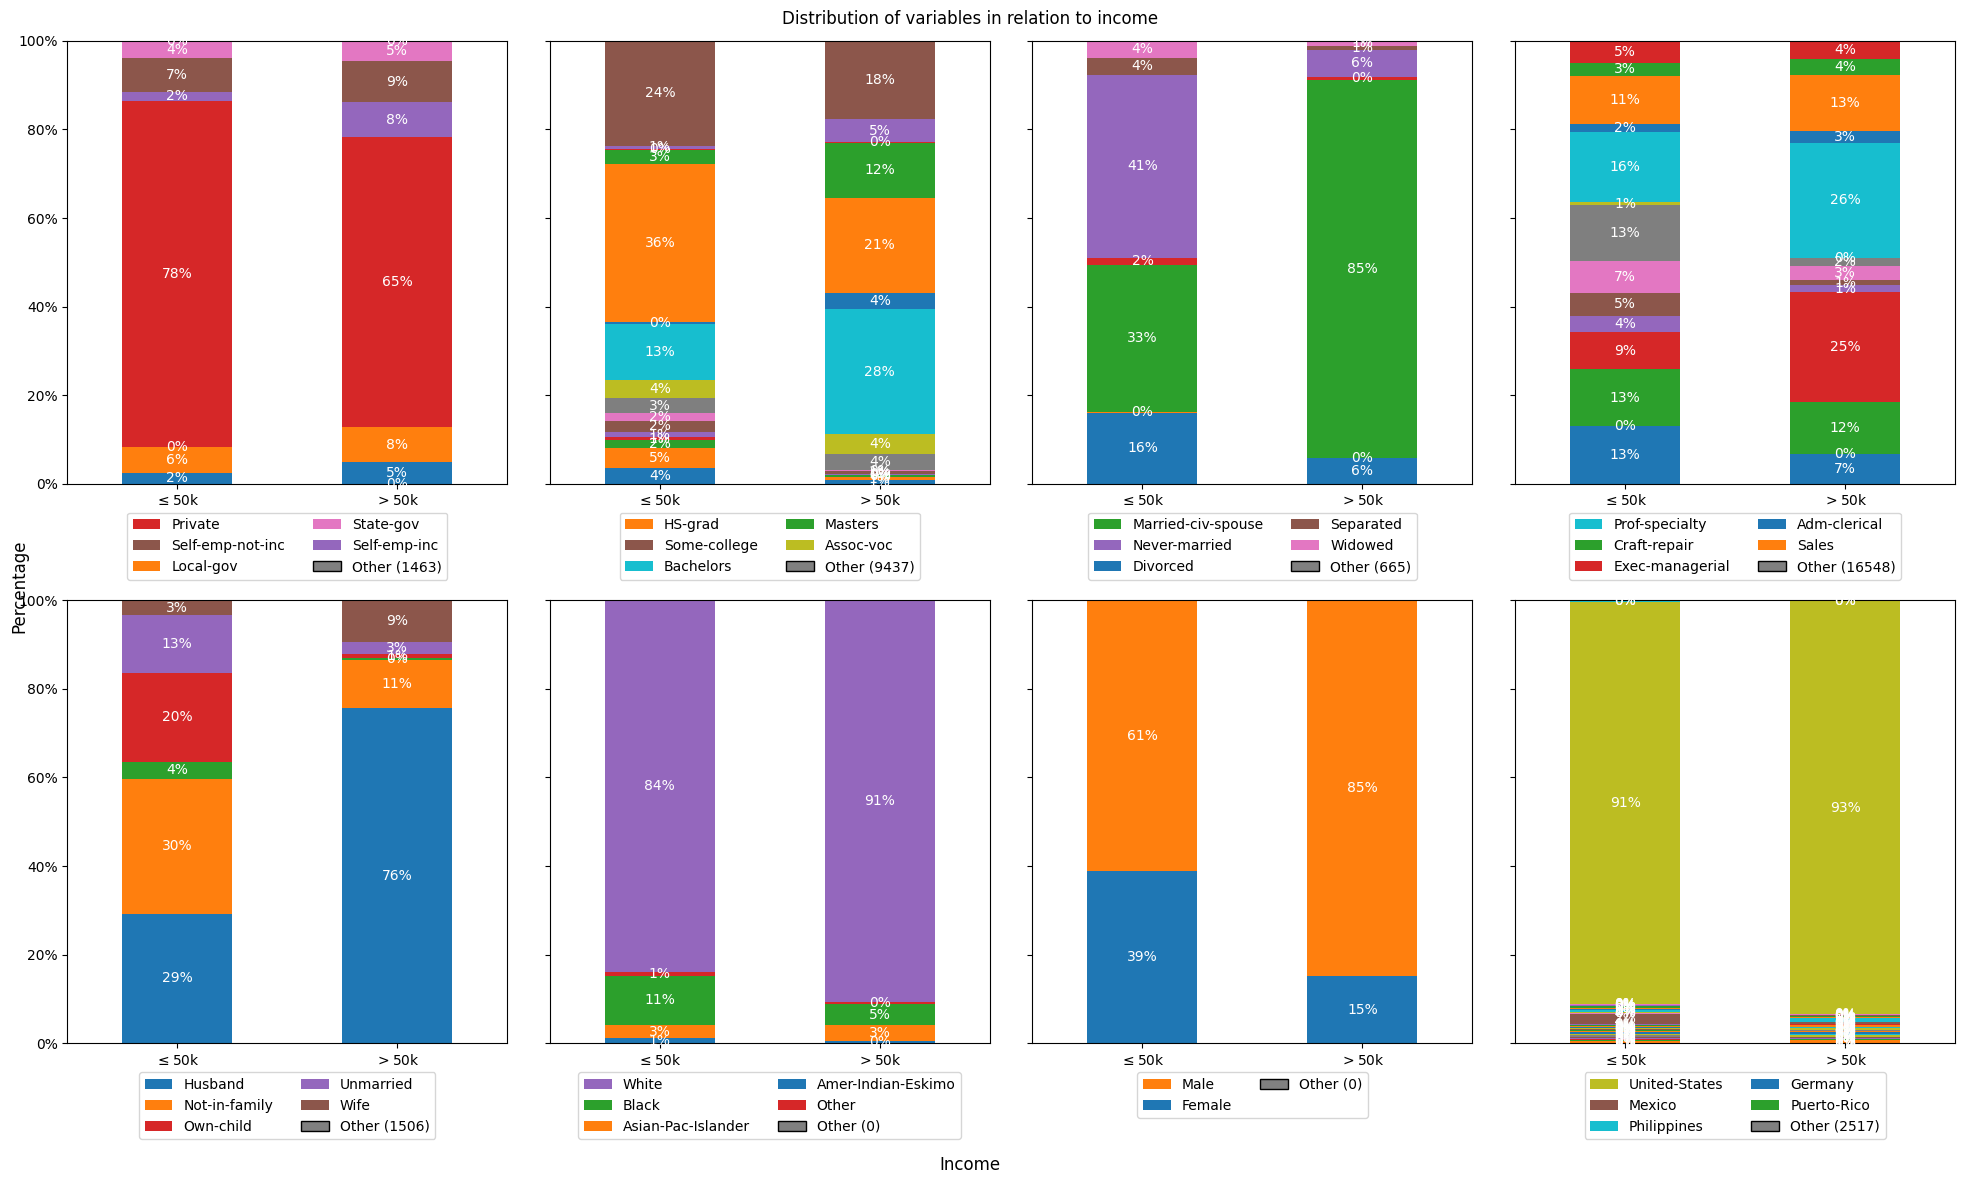

In [306]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(df['income'], df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.savefig('figs/distribution_categroical_hue_income.png')
plt.show()

Nun schauen wir, wie die Klassen **0** und **1** innerhalb der kategorialen Variablen verteilt sind:

### Race

In [307]:
race_counts = df.groupby('race')['income'].value_counts().unstack()
print(race_counts)

df = df.drop('race',axis= 1)
categorical.remove('race')

income                  0      1
race                            
Amer-Indian-Eskimo    415     55
Asian-Pac-Islander   1110    409
Black                4119    566
Other                 356     50
White               31155  10607


### Occupation

In [308]:
occupation_counts = df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)

income                0     1
occupation                   
Adm-clerical       4843   768
Armed-Forces         10     5
Craft-repair       4729  1383
Exec-managerial    3178  2908
Farming-fishing    1317   173
Handlers-cleaners  1934   138
Machine-op-inspct  2650   372
Other-service      4719   204
Priv-house-serv     239     3
Prof-specialty     5932  3049
Protective-serv     675   308
Sales              4029  1475
Tech-support       1026   420
Transport-moving   1874   481


In [309]:
old_labels = ["Adm-clerical", "Armed-Forces", "Craft-repair", "Farming-fishing", "Handlers-cleaners", "Machine-op-inspct", "Priv-house-serv", "Protective-serv", "Transport-moving"]
new_label = "blue" # handwerk

df.loc[df["occupation"].isin(old_labels), "occupation"] = new_label

old_labels = ["Exec-managerial", "Other-service", "Prof-specialty", "Sales", "Tech-support"]
new_label = "white" # büro

df.loc[df["occupation"].isin(old_labels), "occupation"] = new_label
occupation_counts = df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)

income          0     1
occupation             
blue        18271  3631
white       18884  8056


### Education

In [310]:
education_counts = df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

income            0     1
education                
10th           1302    87
11th           1720    92
12th            609    48
1st-4th         239     8
5th-6th         482    27
7th-8th         893    62
9th             715    41
Assoc-acdm     1188   413
Assoc-voc      1539   522
Bachelors      4712  3313
Doctorate       163   431
HS-grad       13281  2503
Masters        1198  1459
Preschool        82     1
Prof-school     217   617
Some-college   8815  2063


In [311]:
old_labels = ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th"]
new_label = "Pre-Highschool"

df.loc[df["education"].isin(old_labels), "education"] = new_label

old_labels = ["Bachelors", "Masters", "Doctorate", "Assoc-acdm", "Assoc-voc", "Prof-school", "Some-college"]
new_label = "Academic"

df.loc[df["education"].isin(old_labels), "education"] = new_label

education_counts = df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

income              0     1
education                  
Academic        17832  8818
HS-grad         13281  2503
Pre-Highschool   6042   366


### Workclass

In [312]:
workclass_counts = df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

income                  0       1
workclass                        
Federal-gov         871.0   561.0
Local-gov          2209.0   927.0
Never-worked         10.0     0.0
Private           29053.0  7652.0
Self-emp-inc        757.0   938.0
Self-emp-not-inc   2785.0  1077.0
State-gov          1451.0   530.0
Without-pay          19.0     2.0


In [313]:
df = df.drop(df[df['workclass'] == 'Never-worked'].index)
df = df.drop(df[df['workclass'] == 'Without-pay'].index)


old_labels = ["Federal-gov", "Local-gov", "State-gov"]
new_label = "Gov"

df.loc[df["workclass"].isin(old_labels), "workclass"] = new_label

workclass_counts = df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

income                0     1
workclass                    
Gov                4531  2018
Private           29053  7652
Self-emp-inc        757   938
Self-emp-not-inc   2785  1077


### Relationship

In [314]:
relationship_counts = df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

income              0     1
relationship               
Husband         10863  8845
Not-in-family   11306  1276
Other-relative   1453    52
Own-child        7456   110
Unmarried        4814   309
Wife             1234  1093


In [315]:
old_labels = ["Husband", "Wife"]
new_label = "Married"

df.loc[df["relationship"].isin(old_labels), "relationship"] = new_label

relationship_counts = df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

income              0     1
relationship               
Married         12097  9938
Not-in-family   11306  1276
Other-relative   1453    52
Own-child        7456   110
Unmarried        4814   309


### Sex

In [316]:
sex_counts = df.groupby('sex')['income'].value_counts().unstack().fillna(0)
print(sex_counts)

income      0     1
sex                
Female  14414  1768
Male    22712  9917


### Martial Status

In [317]:
marital_counts = df.groupby('marital-status')['income'].value_counts().unstack().fillna(0)
print(marital_counts)

df = df.drop('marital-status', axis= 1)
categorical.remove('marital-status')

income                     0     1
marital-status                    
Divorced                5961   671
Married-AF-spouse         23    14
Married-civ-spouse     12383  9982
Married-spouse-absent    568    58
Never-married          15371   733
Separated               1431    99
Widowed                 1389   128


### Native Country

In [318]:
native_country_counts = df.groupby('native-country')['income'].value_counts().unstack().fillna(0)
print(native_country_counts)

df = df.drop('native-country',axis= 1)
categorical.remove('native-country')

income                            0        1
native-country                              
Cambodia                       19.0      9.0
Canada                        119.0     63.0
China                          86.0     36.0
Columbia                       81.0      4.0
Cuba                          104.0     34.0
Dominican-Republic             98.0      5.0
Ecuador                        39.0      6.0
El-Salvador                   144.0     11.0
England                        80.0     47.0
France                         22.0     16.0
Germany                       148.0     58.0
Greece                         31.0     18.0
Guatemala                      85.0      3.0
Haiti                          66.0      9.0
Holand-Netherlands              1.0      0.0
Honduras                       18.0      2.0
Hong                           22.0      8.0
Hungary                        13.0      6.0
India                          89.0     62.0
Iran                           37.0     22.0
Ireland   

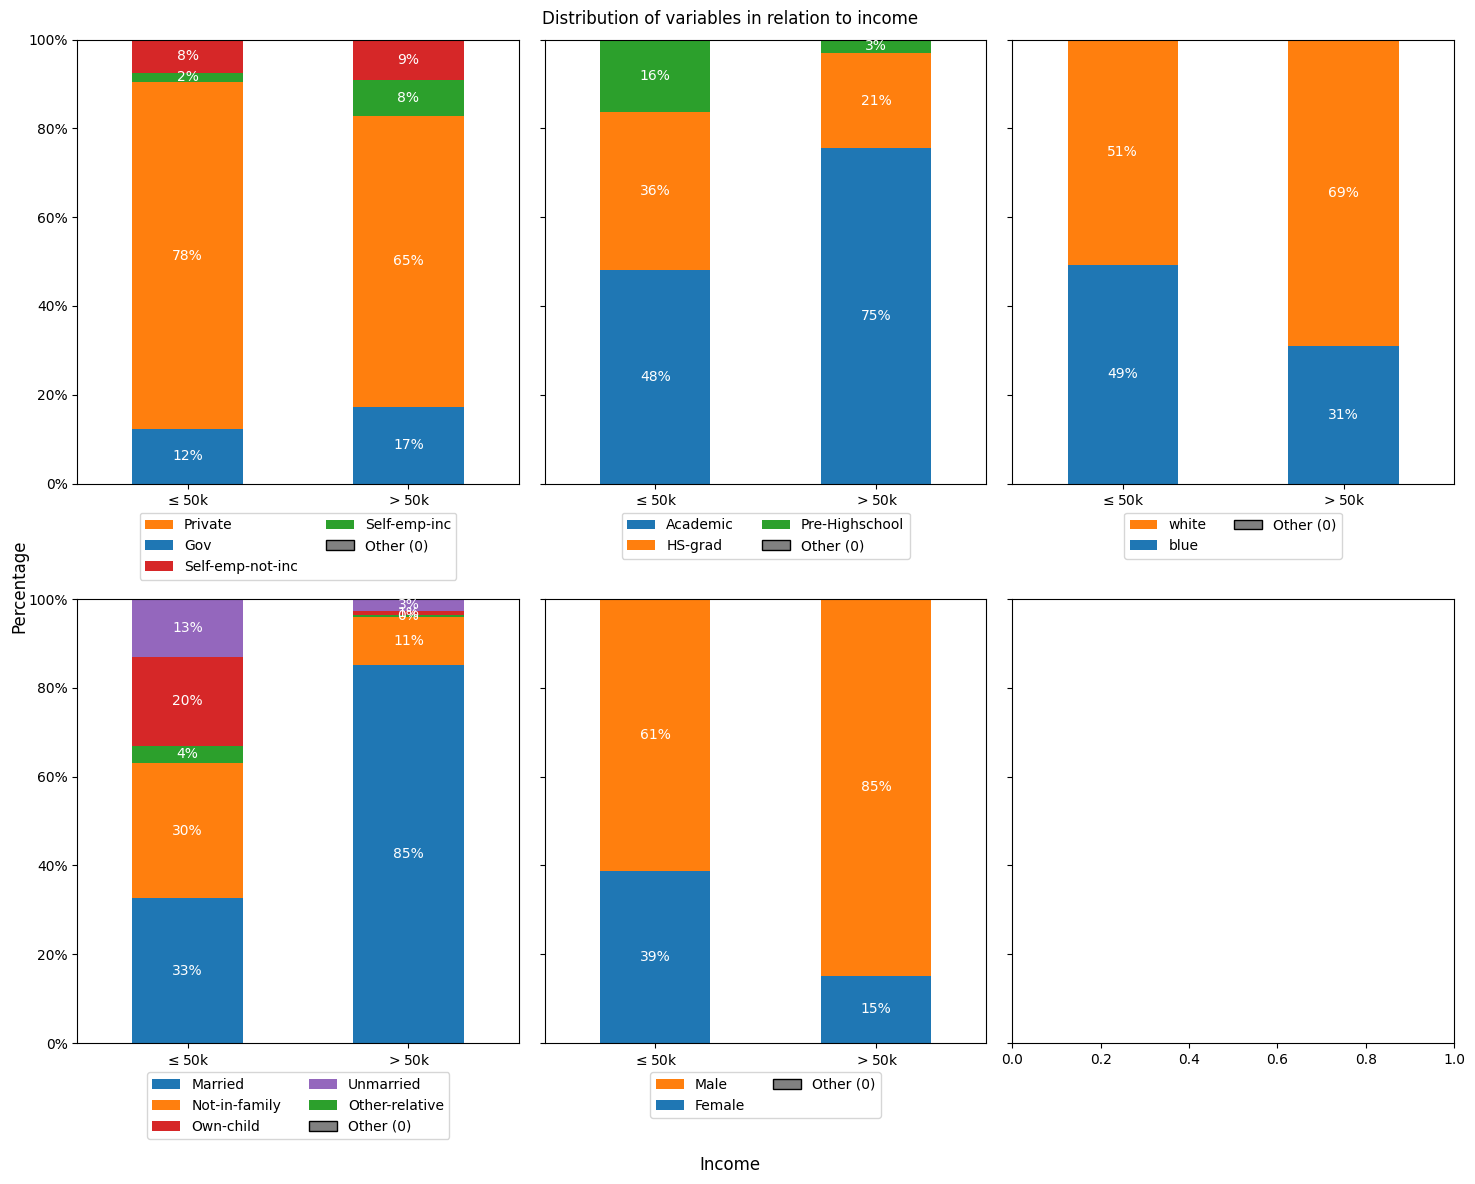

In [319]:
rows=2
cols=3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(df['income'], df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.savefig('figs/distribution_categroical_hue_income_modified.png')
plt.show()

## Kodierung & Skalierung der Daten <a class="scale" id="scale"></a>

### OneHot Codierung der kategorialen Variablen

In [320]:
print(f'Dataframe Shape before encoding: {df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
df = onehot_encoder.fit_transform(df)

df = df.drop(["workclass_4", "education_3", "occupation_2", "relationship_5", "sex_2"], axis=1)

print(f'Dataframe Shape after encoding: {df.shape}')

df.head()

Dataframe Shape before encoding: (48811, 11)
Dataframe Shape after encoding: (48811, 17)


,age,workclass_1,workclass_2,workclass_3,fnlwgt,education_1,education_2,occupation_1,relationship_1,relationship_2,relationship_3,relationship_4,sex_1,capital-gain,capital-loss,hours-per-week,income
0,39,1,0,0,77516,1,0,1,1,0,0,0,1,100,0,40,0
1,50,0,1,0,83311,1,0,0,0,1,0,0,1,0,0,13,0
2,38,0,0,1,215646,0,1,1,1,0,0,0,1,0,0,40,0
3,53,0,0,1,234721,0,0,1,0,1,0,0,1,0,0,40,0
4,28,0,0,1,338409,1,0,0,0,1,0,0,0,0,0,40,0


### Skalierung der Daten

In [321]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Finale Datensätze

Datensatz 1 (aufbereitet und one-hot codiert)

In [322]:
x_train, x_test, y_train, y_test = train_test_split(df.drop("income", axis=1), df["income"], test_size=0.2, shuffle=False)
df.head()

,age,workclass_1,workclass_2,workclass_3,fnlwgt,education_1,education_2,occupation_1,relationship_1,relationship_2,relationship_3,relationship_4,sex_1,capital-gain,capital-loss,hours-per-week,income
0,39,1,0,0,77516,1,0,1,1,0,0,0,1,100,0,40,0
1,50,0,1,0,83311,1,0,0,0,1,0,0,1,0,0,13,0
2,38,0,0,1,215646,0,1,1,1,0,0,0,1,0,0,40,0
3,53,0,0,1,234721,0,0,1,0,1,0,0,1,0,0,40,0
4,28,0,0,1,338409,1,0,0,0,1,0,0,0,0,0,40,0


Datensatz 2 (aufbereitet, one-hot codiert & min-max skaliert)

In [323]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(df_scaled.drop("income", axis=1), df_scaled["income"], test_size=0.2, shuffle=False)
df_scaled.head()

,age,workclass_1,workclass_2,workclass_3,fnlwgt,education_1,education_2,occupation_1,relationship_1,relationship_2,relationship_3,relationship_4,sex_1,capital-gain,capital-loss,hours-per-week,income
0,0.301370,1.0,0.0,0.0,0.044131,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.397959,0.0
1,0.452055,0.0,1.0,0.0,0.048052,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.122449,0.0
2,0.287671,0.0,0.0,1.0,0.137581,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.397959,0.0
3,0.493151,0.0,0.0,1.0,0.150486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.397959,0.0
4,0.150685,0.0,0.0,1.0,0.220635,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.397959,0.0


## PCA <a class="pca" id="pca"></a>

In [324]:
pca_2 = PCA(n_components=2)
pca_2_comp = pca_2.fit_transform(x_train_scaled)

df_pca_2 = pd.DataFrame(data=pca_2_comp, columns=['principal component 1', 'principal component 2'])
df_pca_2['income'] = y_train_scaled

In [325]:
df_pca_2

,principal component 1,principal component 2,income
0,-0.555817,-0.032720,0.0
1,-0.707004,0.919098,0.0
2,0.992767,-0.492945,0.0
3,0.504053,0.647384,0.0
4,-0.635128,0.115931,0.0
...,...,...,...
39043,-0.120424,0.330877,0.0
39044,0.709140,0.518831,0.0
39045,-0.553189,0.620532,0.0
39046,-0.805695,0.903157,1.0


In [326]:
print('\nDescription')
print(df_pca_2.describe())

print('\nInfo')
print(df_pca_2.info())


Description
       principal component 1  principal component 2        income
count           3.904800e+04           3.904800e+04  39048.000000
mean           -1.674092e-17          -3.457363e-17      0.240140
std             6.752513e-01           6.537731e-01      0.427174
min            -1.028657e+00          -1.101657e+00      0.000000
25%            -6.036177e-01          -5.885380e-01      0.000000
50%            -1.845810e-01          -1.513917e-01      0.000000
75%             6.109996e-01           6.314644e-01      0.000000
max             1.100761e+00           1.116227e+00      1.000000

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39048 entries, 0 to 39047
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  39048 non-null  float64
 1   principal component 2  39048 non-null  float64
 2   income                 39048 non-null  float64
dtypes: float64(3)


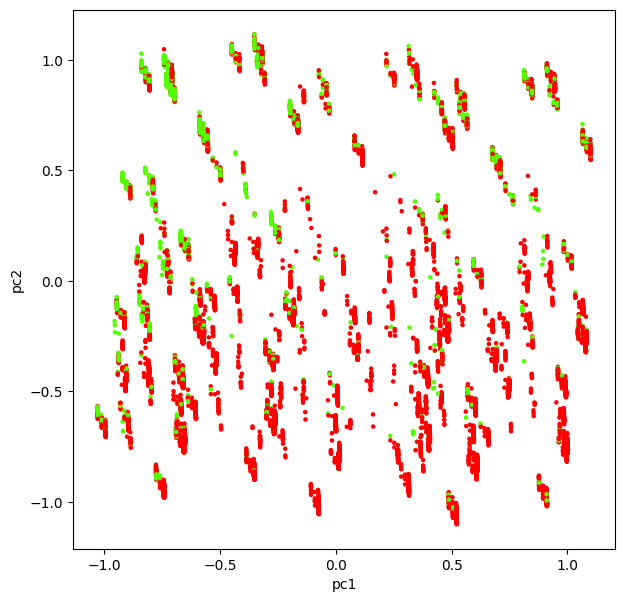

In [327]:
plt.figure(figsize=(7,7))
plt.scatter(df_pca_2['principal component 1'],df_pca_2['principal component 2'],c=df_pca_2['income'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.savefig('figs/pca.png')
plt.show()

In [328]:
pca = PCA()
df_pca = pca.fit_transform(x_train_scaled)

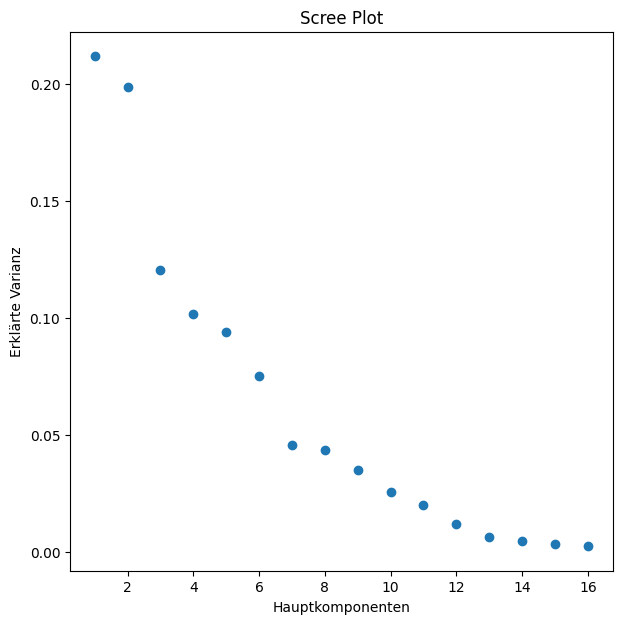

In [329]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca.n_components_) + 1
plt.scatter(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.savefig('figs/scree_plot.png')
plt.show()

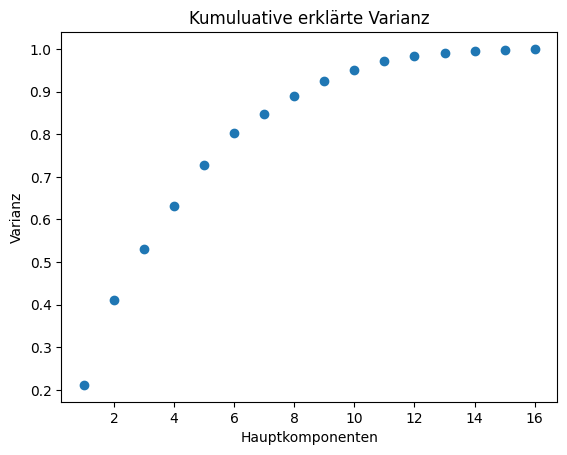

In [330]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Varianz')
plt.title('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.savefig('figs/variance.png')
plt.show()

In [331]:
pca_8 = PCA(n_components=8)
df_pca_8 = pca_8.fit_transform(x_train_scaled)
df_pca_8_test = pca_8.transform(x_test_scaled)

# Konstante 1er Spalte hinzufügen für Beta0
df_pca_8 = statsmodels.tools.add_constant(df_pca_8)
df_pca_8_test = statsmodels.tools.add_constant(df_pca_8_test)

## Clustering <a class="clustering" id="clustering"></a>

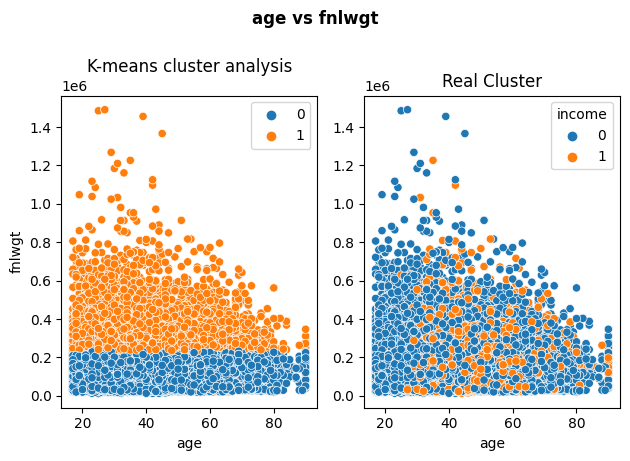

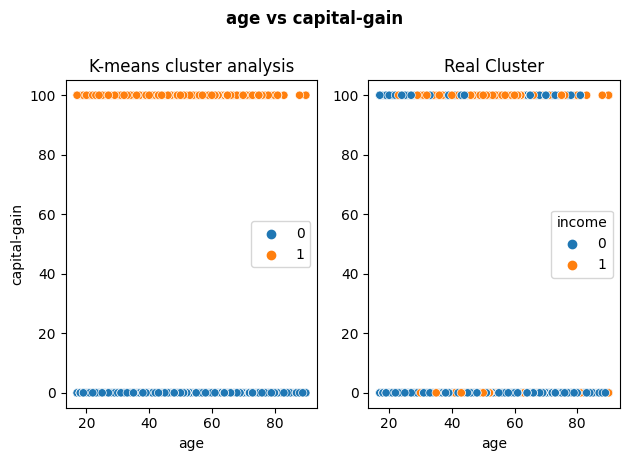

KeyboardInterrupt: 

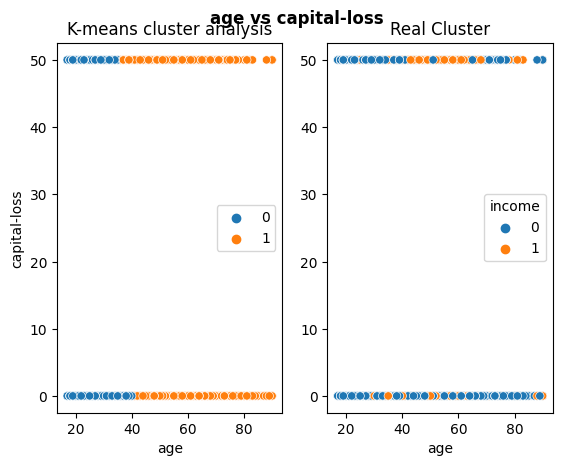

In [332]:
numeric_combinations = list(combinations(numeric, 2))

for combination in numeric_combinations:
    first = combination[0]
    second = combination[1]
    x = df[first]
    y = df[second]
    data = pd.concat([x, y], axis=1)

    kmeans = KMeans(n_clusters=2, random_state=None, n_init='auto')
    kmeans.fit(data)

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=first, y=second, hue=kmeans.labels_)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('K-means cluster analysis')

    plt.subplot(1, 2, 2, sharey=plt.gca())
    sns.scatterplot(data=df, x=first, y=second, hue='income')
    plt.xlabel(first)
    plt.ylabel('')
    plt.title('Real Cluster')

    plt.suptitle(f"{first} vs {second}", y=0.95, fontsize=12, fontweight='bold') 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figs/{first}-{second}.png')
    plt.show()

# Modelle <a class="model" id="model"></a>

Konstante 1er Spale für Beta0 hinzufügen

In [ ]:
x_train = statsmodels.tools.add_constant(x_train)
x_test = statsmodels.tools.add_constant(x_test)
x_train.head()

x_train_scaled = statsmodels.tools.add_constant(x_train_scaled)
x_test_scaled = statsmodels.tools.add_constant(x_test_scaled)
x_train_scaled.head()

## Logit <a class="logit" id="logit"></a>

In [ ]:
model = Logit(y_train_scaled, x_train_scaled).fit(method='newton')

In [ ]:
model.mle_retvals

In [ ]:
print(model.summary2())

In [ ]:
y_predict = model.predict(x_test_scaled)

In [ ]:
prediction = list(map(round, y_predict))
  
print('Actual values', list(y_test_scaled.values))
print('Predictions :', prediction)

In [ ]:
cm = confusion_matrix(y_test_scaled, prediction) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test_scaled, prediction)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit - scaled ({accuracy:.2%})")
plt.savefig('figs/logit-scaled.png')
plt.show()

print(f'Test accuracy = {accuracy_score(y_test_scaled, prediction).round(4)*100} %')

## Logit mit PCA <a class="logit-pca" id="logit-pca"></a>

In [ ]:
model_pca = Logit(y_train_scaled, df_pca_8).fit(method='newton')

In [ ]:
model_pca.summary2()

In [ ]:
y_predict_scaled = model_pca.predict(df_pca_8_test)

In [ ]:
prediction2 = list(map(round, y_predict_scaled))
  
# comparing original and predicted values of y
print('Actual values', list(y_test_scaled.values))
print('Predictions :', prediction2)

In [ ]:
cm2 = confusion_matrix(y_test_scaled, prediction2) 
cmn2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test_scaled, prediction2)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn2, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit - PCA ({accuracy:.2%})")
plt.savefig('figs/logit-pca.png')
plt.show()
  
# accuracy score of the model
print(f'Test accuracy = {accuracy_score(y_test_scaled, prediction2).round(4)*100} %')

## Logit mit nicht lineaer transformierten Daten <a class="logit-transformed" id="logit-transformed"></a>

In [ ]:
x_train['age'] = np.log(x_train['age'])
x_train['fnlwgt'] = np.log(x_train['fnlwgt'])

x_test['age'] = np.log(x_test['age'])
x_test['fnlwgt'] = np.log(x_test['fnlwgt'])

In [ ]:
model_transformed = Logit(y_train, x_train).fit(method='newton')

In [ ]:
model_transformed.summary2()

In [ ]:
y_predict_transformed = model_transformed.predict(x_test)
prediction_transformed = list(map(round, y_predict_transformed))
  
print('Actual values', list(y_test.values))
print('Predictions :', prediction_transformed)

In [ ]:
cm3 = confusion_matrix(y_test, prediction_transformed) 
cmn3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test, prediction_transformed)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn3, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit - log transformed ({accuracy:.2%})")
plt.savefig('figs/logit-log-transformed.png')
plt.show()
  
print(f'Test accuracy = {accuracy:.2%} %')

In [ ]:
#df_pca_8.drop("const", axis=1)
x_train.drop("const", axis=1)
x_train_scaled.drop("const", axis=1)

## Random Forest <a class="random" id="random"></a>

In [ ]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_train_scaled, y_train_scaled)

y_predict = forest.predict(x_test_scaled)
 
forest_score_accuracy = forest.score(x_test_scaled, y_test_scaled)

cm_forest = confusion_matrix(y_test_scaled, y_predict)
cm_forest_normalized = cm_forest.astype('float') / cm_forest.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_forest_normalized, cmap='viridis', annot=True, fmt=".2%", vmin=0, vmax=1)
plt.title(f'Random Forest ({forest_score_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs/random-forest.png')

plt.show()

In [ ]:
"""
fig = plt.figure(figsize=(15, 10))
plot_tree(forest.estimators_[0], 
    feature_names=x_train_scaled.columns,
    class_names=['$\leq50$k', '$>50$k'], 
    filled=True, impurity=True, 
    rounded=True)
fig.savefig('random_forest_model.png')
"""

## Hypertuning

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120, 130, 140],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [5, 6, 7, 8],
    'min_samples_split': [12, 14, 16, 18],
    'n_estimators': [30, 40, 45, 50, 60]
}

In [ ]:
forest_tuned = RandomForestClassifier()

grid_search = GridSearchCV(estimator=forest_tuned, param_grid=param_grid, cv=3, n_jobs=-1)

grid_search.fit(x_train_scaled, y_train_scaled)

In [ ]:
grid_search.best_params_

In [ ]:
forest_tuned_new = RandomForestClassifier(**grid_search.best_params_)

forest_tuned_new.fit(x_train_scaled, y_train_scaled)

y_predict = forest_tuned_new.predict(x_test_scaled)
 
forest_score_accuracy = forest_tuned_new.score(x_test_scaled, y_test_scaled)

cm_forest = confusion_matrix(y_test_scaled, y_predict)
cm_forest_normalized = cm_forest.astype('float') / cm_forest.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_forest_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Random Forest - tuned ({forest_score_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs/random-tuned.png')

plt.show()

## Neuronales Netz <a class="neruonal" id="neruonal"></a>

In [ ]:
epochs = 250

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=21, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='relu'))
model.add(tf.keras.layers.Dense(units=2, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train_scaled, y_train_scaled, validation_split=0.1, batch_size=16, epochs=epochs)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='nn_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('figs/nn_accuracy_loss.png')

plt.show()

In [ ]:
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.round(y_pred_prob).flatten()

cm_nn = confusion_matrix(y_test_scaled, y_pred)
cm_nn_normalized = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
nn_accuracy = accuracy_score(y_test_scaled, y_pred)

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_nn_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Neuronal Network ({nn_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs/nn_confusion_matrix.png')

plt.show()

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("layer1", min_value=15, max_value=21, step=1),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )    
    ),
    model.add(
        keras.layers.Dense(
            units=hp.Int("layer2", min_value=10, max_value=15, step=1),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )    
    ),
    model.add(
        keras.layers.Dense(
            units=hp.Int("layer3", min_value=5, max_value=10, step=1),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    ),
    model.add(
        keras.layers.Dense(
            units=hp.Int("layer4", min_value=2, max_value=5, step=1),
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    ),
    model.add(keras.layers.Dense(1, activation="sigmoid")),
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), 
        loss="binary_crossentropy", 
        metrics=["accuracy"]
    )
    return model


In [ ]:
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=epochs,
    overwrite=True,
    factor=3,
    directory='neuronal-network',
    project_name='income-classification'
)

In [ ]:
tuner.search_space_summary()
X_train_scaled, X_val_scaled, Y_train_scaled, Y_val_scaled = train_test_split(x_train_scaled, y_train_scaled, shuffle=False, test_size=0.1)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

tuner.search(X_train_scaled, Y_train_scaled, epochs=epochs, validation_data=(X_val_scaled, Y_val_scaled), 
             callbacks=[stop_early])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('layer1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

best_model = tuner.hypermodel.build(best_hps)

In [ ]:
history = best_model.fit(X_train_scaled, Y_train_scaled, validation_data=(X_val_scaled, Y_val_scaled), epochs=epochs, verbose=0)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
best_model.summary()

In [ ]:
tf.keras.utils.plot_model(best_model, to_file='nn_best_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('figs/nn_accuracy_loss_tuned.png')

plt.show()

In [ ]:
y_pred_prob = best_model.predict(x_test_scaled)
y_pred = np.round(y_pred_prob).flatten()

cm_nn = confusion_matrix(y_test_scaled, y_pred)
cm_nn_normalized = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
nn_accuracy = accuracy_score(y_test_scaled, y_pred)

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_nn_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Neuronal Network - tuned ({nn_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs/nn_tuned_confusion_matrix.png')

plt.show()

## Vergleich der Modelle <a class="compare" id="compare"></a>

## TODO